<img src="imgs/mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S8: Contaminación en Madrid

## Objetivos:

* Experimentar con datos de Open Data Madrid.
* Trabajar con datos de localización.
* Representar la contaminación en Madrid del mes de septiembre de 2018.

**NOTA:** Actualmente Google Chrome tiene un problema al renderizar gráficos complejos con folium. Por eso **se recomienda encarecidamente** el realizar esta sesión con __[Mozilla Firefox](https://www.mozilla.org/es-ES/firefox/new/)__. Si nuestro navegador por defecto no es Firefox, podremos acceder al servidor de Jupyter Notebook una vez lo hayamos lanzado, copiando la url que contiene el token en el navegador Firefox.

<img src="imgs/notebookrun.png"/>

## Inicializamos entorno

In [1]:
import numpy as np
import pandas as pd
import re
import folium
import random
from folium import plugins

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

estaciones = pd.read_csv("data/madrid_estaciones_cont.csv")
contamina = pd.read_csv('data/contamina_2018_09_diario.csv')

random.seed(1234)



Empezaremos a trabajar con los puestos de medida de la contaminación de Madrid. 

In [2]:
estaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       0 non-null      float64
 1   NÚMERO           38 non-null     object 
 2   ESTACIÓN         40 non-null     object 
 3   DIRECCIÓN        40 non-null     object 
 4   LONGITUD         37 non-null     object 
 5   LATITUD          37 non-null     object 
 6   ALTITUD          37 non-null     float64
 7   TIPO ESTACION *  37 non-null     object 
 8   NO2              37 non-null     object 
 9   SO2              12 non-null     object 
 10  CO               17 non-null     object 
 11  PM10             14 non-null     object 
 12  PM2,5            7 non-null      object 
 13  O3               23 non-null     object 
 14  BTX              8 non-null      object 
 15  HC               4 non-null      object 
 16  UV               3 non-null      object 
 17  VV               6

Haremos uso de la función proporcionada en el worksheet para transformar las coordenadas de grados, minutos y segundos a meridiano.

In [3]:
def convertir_coords(s):
    # https://pythex.org/
    import re
    if s is np.nan:
        return np.nan
    
    degrees, minutes, seconds, direction = re.split('[º \' "]+', s)
    seconds = seconds.replace(",", ".")
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','O'):
        dd*= -1
    
    return dd

## Preprocesamiento y exploración de los datos de sensores

Aplica las transformaciones necesarias y construye un mapa de los datos de exploración de sensores de contaminación.

In [4]:
# TU CÓDIGO AQUÍ
estaciones.head()

,Unnamed: 0,NÚMERO,ESTACIÓN,DIRECCIÓN,LONGITUD,LATITUD,ALTITUD,TIPO ESTACION *,NO2,SO2,...,BTX,HC,UV,VV,DV,TMP,HR,PRB,RS,LL
0,NaN,4,Pza. de España,Plaza de España,"3º 42' 44,09''O","40º 25' 25,87''N",635.0,UT,X,X,...,NaN,NaN,NaN,X,X,X,X,NaN,NaN,X
1,NaN,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,"3º 40' 56,35''O","40º 25' 17,63''N",670.0,UT,X,X,...,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,"3º 40' 38,48''O","40º 27' 05,31''N",708.0,UT,X,NaN,...,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
3,NaN,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,"3º 38' 21,24''O","40º 26' 24,17''N",693.0,UF,X,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X
4,NaN,17,Villaverde,C/. Juan Peñalver,"3º 42' 47,96''O","40º 20' 49,70''N",604.0,UF,X,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Convertimos la longitud y la latitud que vienen en grados, minutos, segundos.
estaciones['Lon'] = estaciones['LONGITUD'].apply(convertir_coords)
estaciones['Lat'] = estaciones['LATITUD'].apply(convertir_coords)
estaciones[['ESTACIÓN', 'LATITUD', 'LONGITUD', 'Lat', 'Lon']].head()

,ESTACIÓN,LATITUD,LONGITUD,Lat,Lon
0,Pza. de España,"40º 25' 25,87''N","3º 42' 44,09''O",40.423853,-3.712247
1,Escuelas Aguirre,"40º 25' 17,63''N","3º 40' 56,35''O",40.421564,-3.682319
2,Avda. Ramón y Cajal,"40º 27' 05,31''N","3º 40' 38,48''O",40.451475,-3.677356
3,Arturo Soria,"40º 26' 24,17''N","3º 38' 21,24''O",40.440047,-3.639233
4,Villaverde,"40º 20' 49,70''N","3º 42' 47,96''O",40.347139,-3.713322


In [6]:
# Eliminamos la información que no viene geolocalizada ya que no la vamos a poder trabajar con ella ni se puede visualizar.

estaciones = estaciones[~estaciones['Lat'].isna()]

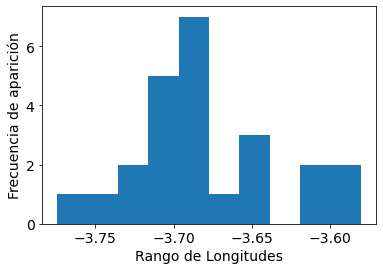

In [7]:
# Eliminamos posibles latitudes y longitudes "outliers" que se salen del rango de las que correspondería a Madrid capital
# Las coordenadas de Madrid capital serían [40.4167,  -3.70325]
estaciones = estaciones[estaciones['Lat'] > 40.]
estaciones = estaciones[(estaciones['Lon'] > -4.)& (estaciones['Lon'] < -3.)]
estaciones['Lon'].plot(kind = "hist");

plt.xlabel('Rango de Longitudes')
plt.ylabel('Frecuencia de aparición')
plt.grid(False)
plt.show()

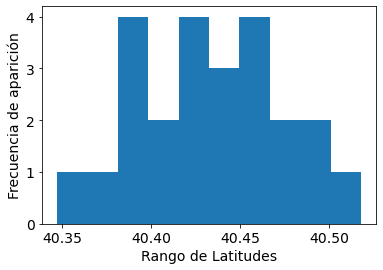

In [8]:
estaciones['Lat'].plot(kind = "hist");
plt.xlabel('Rango de Latitudes')
plt.ylabel('Frecuencia de aparición')
plt.grid(False)
plt.show()

In [9]:
#Una vez que hemos transformado la longitud y la latitud y hemos eliminado información no geolocalizada
#Pasamos a representarla en una mapa.

#MADRID_COORDS = [40.4167,  -3.70325]
# Estamos que la la posición de Madrid es la media de todas las latitudes y longitudes de las distintas estaciones.
MADRID_COORDS = [estaciones['Lat'].mean(), estaciones['Lon'].mean()]

m = folium.Map(MADRID_COORDS, zoom_start=11)

for index, row in estaciones.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        folium.CircleMarker([row['Lat'], row['Lon']],
                            radius=2,
                            popup='<b>Est:</b> '+str(row['NÚMERO']) +"</br> <b>Dir.</b>:"+ row['DIRECCIÓN'],
                            fill_color="#3db7e4",
                           ).add_to(m)
        
# convertimos coordenadas a array de dos dimensiones
stationArr = estaciones[['Lat', 'Lon']].values

# ploteamos heatmap
from folium import plugins
m.add_child(plugins.HeatMap(stationArr, radius=25))
m

## Representación de contaminación durante el mes de septiembre

Preprocesa y representa los datos de contaminación en Madrid para el mes de septiembre. Tienes los datos cargados en la variable `contamina`.

In [10]:
# TU CÓDIGO AQUÍ

# Echamos un vistazo a los campos que contiene el dataframe de contamina, para ver número de registros, la existencia de nan
# tipo de datos, ..., etc
contamina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ESTACION  720 non-null    int64  
 1   MAGNITUD  720 non-null    int64  
 2   ANO       720 non-null    int64  
 3   MES       720 non-null    int64  
 4   DIA       720 non-null    int64  
 5   H08       720 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 33.9 KB


In [11]:
#Visualizamos los datos
contamina

,ESTACION,MAGNITUD,ANO,MES,DIA,H08
0,4,7,2018,9,1,3.0
1,4,7,2018,9,2,3.0
2,4,7,2018,9,3,36.0
3,4,7,2018,9,4,51.0
4,4,7,2018,9,5,10.0
...,...,...,...,...,...,...
715,60,7,2018,9,26,1.0
716,60,7,2018,9,27,6.0
717,60,7,2018,9,28,22.0
718,60,7,2018,9,29,1.0


In [12]:
# Visualizamos el rango en el que se muestran los valores de la sustancia H08 durante el mes de septiembre.

print("Máximo valor de contaminación: {}".format(max(contamina['H08'])))
print("Mínimo valor de contaminación: {}".format(min(contamina['H08'])))

Máximo valor de contaminación: 133.0
Mínimo valor de contaminación: 0.0


In [13]:
#Generamos un campo datetime que nos facilitará trabajar y nalizar los datos como una serie temporal.

contamina['datestr'] = contamina['ANO'].astype(str) +"-"+ contamina['MES'].astype(str) +"-"+ contamina['DIA'].astype(str)
contamina['date'] = contamina.apply(lambda x: pd.to_datetime(x['datestr']), axis=1)
contamina.head()

,ESTACION,MAGNITUD,ANO,MES,DIA,H08,datestr,date
0,4,7,2018,9,1,3.0,2018-9-1,2018-09-01
1,4,7,2018,9,2,3.0,2018-9-2,2018-09-02
2,4,7,2018,9,3,36.0,2018-9-3,2018-09-03
3,4,7,2018,9,4,51.0,2018-9-4,2018-09-04
4,4,7,2018,9,5,10.0,2018-9-5,2018-09-05


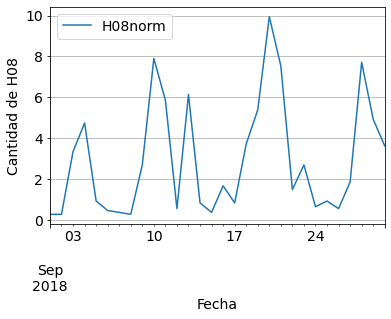

In [14]:
# Normalizamos los datos para que los datos vayan en relación a su media mensual.
contamina['H08norm'] = contamina['H08'] / (contamina['H08'].mean())
contamina[contamina['ESTACION'] == 4].sort_values(by = "date").plot(x = "date", y= "H08norm")
plt.xlabel('Fecha')
plt.ylabel('Cantidad de H08')
plt.grid(True,axis="both")
plt.show()

In [15]:
# Hacemos inner join para relacionar datos de las estaciones, con las mediciones de cada día de septiembre
# que han registrado las estaciones
estaciones['NÚMERO'] = estaciones['NÚMERO'].astype(int)
merged = estaciones.merge(contamina, how = "inner", left_on = "NÚMERO", right_on = "ESTACION")
merged = merged[["ESTACION", "DIRECCIÓN", "Lon", "Lat", "date", "datestr", "H08norm", "H08"]]
merged.head()

,ESTACION,DIRECCIÓN,Lon,Lat,date,datestr,H08norm,H08
0,4,Plaza de España,-3.712247,40.423853,2018-09-01,2018-9-1,0.278854,3.0
1,4,Plaza de España,-3.712247,40.423853,2018-09-02,2018-9-2,0.278854,3.0
2,4,Plaza de España,-3.712247,40.423853,2018-09-03,2018-9-3,3.346243,36.0
3,4,Plaza de España,-3.712247,40.423853,2018-09-04,2018-9-4,4.740511,51.0
4,4,Plaza de España,-3.712247,40.423853,2018-09-05,2018-9-5,0.929512,10.0


In [16]:
# Preparamos los datos como una lista de listas. En que cada lista representa los datos de todas las estaciones para 1 día.
# Esta estructura será la que alimente el mapa de calor animádo en el que se verá como evolucionan los indices de 
# contaminación para cada una de las estaciones.

days = merged['date'].unique()

heatmap_data = []
for d in days:
    day_data = [[row['Lat'], row['Lon'], row['H08norm']] for i, row in merged[merged['date'] == d].iterrows()]
    heatmap_data.append(day_data)
    
heatmap_data

[[[40.423852777777775, -3.7122472222222225, 0.278853601859024],
  [40.42156388888888, -3.6823194444444445, 0.09295120061967467],
  [40.451475, -3.6773555555555553, 0.09295120061967467],
  [40.44004722222222, -3.6392333333333333, 0.09295120061967467],
  [40.34713888888889, -3.713322222222222, 0.09295120061967467],
  [40.394780555555556, -3.7318527777777777, 0.18590240123934934],
  [40.419355555555555, -3.7473472222222224, 0.09295120061967467],
  [40.47692777777778, -3.580030555555555, 1.2083656080557708],
  [40.41920833333333, -3.7031722222222223, 0.18590240123934934],
  [40.40794722222222, -3.6453055555555554, 0.18590240123934934],
  [40.445544444444444, -3.707127777777778, 0.09295120061967467],
  [40.47822777777778, -3.7115416666666667, 0.09295120061967467],
  [40.388152777777776, -3.6515222222222223, 0.18590240123934934],
  [40.398113888888886, -3.6868250000000002, 0.09295120061967467],
  [40.43989722222222, -3.690366666666667, 0.09295120061967467],
  [40.41444444444444, -3.682583333

In [17]:
#MADRID_COORDS = [40.4167,  -3.70325]
MADRID_COORDS = [estaciones['Lat'].mean(), estaciones['Lon'].mean()]
m = folium.Map(MADRID_COORDS, zoom_start=11)

for index, row in estaciones.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        folium.CircleMarker([row['Lat'], row['Lon']],
                            radius=2,
                            popup=row['DIRECCIÓN'],
                            fill_color="#3db7e4",
                           ).add_to(m)


hm = plugins.HeatMapWithTime(heatmap_data, radius = 60)
hm.add_to(m)
m

## Optimización de rutas

En el worksheet hemos hablado de optimización de rutas como un problema recurrente sobretodo para operaciones logísticas. Lamentablemente, no somos capaces de hacerlo por fuerza bruta en problemas grandes y tampoco sin distancias de ruta por carretera reales. Sin embargo, sí que tenemos la distancia haversine.

Imagina que después de una tormenta eléctrica, todos los dispositivos de medición de contaminación en Madrid se han estropeado y que eres el técnico encargado de repararlos. Si la central del técnico está situada en el punto origen propuesto, construye un algoritmo que calcule la ruta óptima, siendo esta la que más sensores permita reparar en menor tiempo posible y obtén la distancia total recorrida.

Estructura del algoritmo propuesta:
* Establecer punto de origen
* Repetir hasta que no queden puntos por visitar:
    * Calcular desde el punto actual la distancia a todos los puntos restantes.
    * Escoger el punto más cercano.
    * Marcar ese punto como punto ya visitado. No queremos visitar un mismo punto varias veces.
    * Establecer como nuevo punto de origen el seleccionado como más cercano.
* Una vez no queden más puntos por visitar, calcula la distancia de vuelta directamente a la central del técnico.

¿Serías capaz de pintar esta ruta en un mapa de folium?

In [18]:
ORIGEN_COORDS = [40.398113888888886, -3.6868250000000002]

def haversine(lon1, lat1, lon2, lat2):
    from math import radians, cos, sin, asin, sqrt
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radio de la tierra en km.
    
    return c * r

In [19]:
# TU ALGORITMO DE RUTA AQUÍ

def calcula_ruta_optima_distancias(df, indice_origen=None, numero_est_origen=None):
    
# Función que a partir de una dataframe con las estaciones, genera un dataframe con el recorrido.
# Como datos de origen del recorrido se le puede pasar el indice que ocupa la estación, o su número de estación
# prevaleciendo este último parámetro sobre el indice por se un dato propio de la estación independendiente del orden
# que pudier tener el listado.

#Inicializamos el df aux que era el df que retorne la función con la información de la ruta

    try:

        aux = df.copy()
        aux['Est_Cercana'] = np.nan
        aux['Dist_Est_Cercana'] = np.nan
        aux['Orden'] = np.nan
        orden = 1

    # Listamos todos las estaciones por las que tenemos que pasar. Lo hacemos identificandolas por su indice    
        sin_visitar_list = list(df.index.values)

    # Si nos pasan el id de estación calculamos su indice.    
        if (numero_est_origen):
            indice_origen=int(estaciones_ruta_df[estaciones_ruta_df['NÚMERO']==numero_est_origen].index.values)
        elif (indice_origen==None):
            print('Debe proporcionar o el número de estación o su indice en el listado')
            return aux

        sin_visitar_list.remove(indice_origen)
    #     print(sin_visitar_list)

        # Calculamos la primera estación más cercana al origen.

        i, d = calcula_menor_distancia(df, indice_origen, sin_visitar_list)
    #     print('Punto mas cercano al origen ',i)
    #     print('Distancia punto mas cercano origen ',d)
        aux.loc[indice_origen, 'Est_Cercana'] = i
        aux.loc[indice_origen, 'Dist_Est_Cercana'] = d
        aux.loc[indice_origen, 'Orden'] = orden

        intermedio = i
        sin_visitar_list.remove(intermedio)

        while (len(sin_visitar_list) > 0):

            i, d = calcula_menor_distancia(df, intermedio, sin_visitar_list)
            aux.loc[intermedio, 'Est_Cercana'] = i
            aux.loc[intermedio, 'Dist_Est_Cercana'] = d
            orden += 1
            aux.loc[intermedio, 'Orden'] = orden

    #         print('Punto mas cercano ',i)
    #         print('Distancia punto mas cercano ',d)
            intermedio = i
            sin_visitar_list.remove(intermedio)

            # Ya hemos vistado todas las estaciones. Volvemos al origen calculando distancia directa
            if (len(sin_visitar_list) == 0):
                #            print('Regresamos a la central desde ', intermedio )
                aux.loc[intermedio, 'Est_Cercana'] = indice_origen
                aux.loc[intermedio, 'Dist_Est_Cercana'] = calcula_distancia(
                    df, intermedio, indice_origen)
                orden += 1
                aux.loc[intermedio, 'Orden'] = orden

    #             print('Con una distancia ',aux.loc[intermedio,'Dist_Est_Cercana'])

    # Creamos una última fila con el origen de nuevo para que el recorrido sea circular

        last_index = len(aux.index)

        aux.loc[last_index] = aux.loc[indice_origen]
        aux.loc[last_index, 'Dist_Est_Cercana'] = 0
        aux.loc[last_index, 'Est_Cercana'] = 0
        orden += 1
        aux.loc[last_index, 'Orden'] = last_index+1

    
    except Exception:
        print('Ha habido un problema para calcular la ruta ... posiblemente el indice o el identificador no son correctos')
        return aux
    
    return aux.sort_values('Orden')



def calcula_menor_distancia(df, origen, sin_visitar):
    
    #Calcula la menor distancia de una estación con el resto de estaciones, siempre validando que no se haya visitado
    dist = 0
    indice = 0
    row_origen = df.loc[origen, :]
    for index, row in df.iterrows():
        if ((index == origen)) | (index not in sin_visitar):
            continue

        if(dist == 0):
            dist = haversine(
                row_origen['Lat'], row_origen['Lon'], row['Lat'], row['Lon'])
            indice = index
        elif (dist > haversine(row_origen['Lat'], row_origen['Lon'], row['Lat'], row['Lon'])):
            dist = haversine(
                row_origen['Lat'], row_origen['Lon'], row['Lat'], row['Lon'])
            indice = index

    return indice, dist


def calcula_distancia(df, origen, destino):
# Calcula distacia entre dos estaciones identificadas por su indice origen y destino
    row_origen = df.loc[origen, :]
    row_destino = df.loc[destino, :]
    dist = haversine(row_origen['Lat'], row_origen['Lon'],
                     row_destino['Lat'], row_destino['Lon'])

    return dist

In [20]:
#Generamos un dataframe con los datos que necesitamos sobre las estaciones.
estaciones_ruta_df=estaciones.copy()
estaciones_ruta_df=estaciones_ruta_df.loc[:,['NÚMERO','ESTACIÓN','DIRECCIÓN','Lon','Lat']]
estaciones_ruta_df

,NÚMERO,ESTACIÓN,DIRECCIÓN,Lon,Lat
0,4,Pza. de España,Plaza de España,-3.712247,40.423853
1,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564
2,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475
3,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047
4,17,Villaverde,C/. Juan Peñalver,-3.713322,40.347139
5,18,Farolillo,Calle Farolillo - C/Ervigio,-3.731853,40.394781
6,24,Casa de Campo,Casa de Campo (Terminal del Teleférico),-3.747347,40.419356
7,27,Barajas Pueblo,"C/. Júpiter, 21 (Barajas)",-3.580031,40.476928
8,35,Pza. del Carmen,Plaza del Carmen esq. Tres Cruces.,-3.703172,40.419208
9,36,Moratalaz,Avd. Moratalaz esq. Camino de los Vinateros,-3.645306,40.407947


In [21]:
# LLamamos a nuestro algoritmo que nos guiara por la mejor ruta ... Lo podemos hacer insertando el indice que ocupa en
# la relación de estaciones o también por su número de estación. Esta preparada para partir de cualuqier estación.

# En este caso partimos de la estación 47 la de Mendez Alvaro. Indice 13

recorrido_estaciones_df=calcula_ruta_optima_distancias(estaciones_ruta_df,numero_est_origen=47)

#Mostramos el dataframe que nos devulve con los datos de la ruta, distancias, orden ...
recorrido_estaciones_df

,NÚMERO,ESTACIÓN,DIRECCIÓN,Lon,Lat,Est_Cercana,Dist_Est_Cercana,Orden
13,47,Mendez Alvaro,C/ Juan de Mariana / Pza. Amanecer Mendez Alvaro,-3.686825,40.398114,15.0,1.872495,1.0
15,49,Parque del Retiro,Paseo Venezuela- Casa de Vacas,-3.682583,40.414444,1.0,0.790556,2.0
1,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,14.0,2.222451,3.0
14,48,Castellana,C/ Jose Gutierrez Abascal,-3.690367,40.439897,2.0,1.934857,4.0
2,11,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,16.0,2.014404,5.0
16,50,Plaza Castilla,Plaza Castilla (Canal),-3.688769,40.465572,11.0,2.895491,6.0
11,39,Barrio del Pilar,Avd. Betanzos esq. C/ Monforte de Lemos,-3.711542,40.478228,23.0,3.467301,7.0
23,60,Tres Olivos,Plaza Tres Olivos,-3.689761,40.500589,20.0,3.329530,8.0
20,57,Sanchinarro,C/ Princesa de Eboli esq C/ Maria Tudor,-3.660503,40.494208,3.0,6.458815,9.0
3,16,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,9.0,3.625574,10.0


In [22]:
#Representamos la ruta en el mapa.
# Añadimos información en cada uno de los puntos que representa una estación

MADRID_COORDS = [estaciones['Lat'].mean(), estaciones['Lon'].mean()]

m = folium.Map(MADRID_COORDS, zoom_start=11)
loc = recorrido_estaciones_df.loc[:,['Lat','Lon']].values

# Creamos los puntos en el mapa.
for index, row in recorrido_estaciones_df.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        
        #El punto inicial
        if((row['Orden']==1) | (row['Orden']==len(recorrido_estaciones_df.index))):
           
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Inicio</b> :'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="blue")
                                ).add_to(m)
        #El punto final    
        elif(row['Orden']==len(recorrido_estaciones_df.index)-1):
           
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Fin</b> :'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="red")
                                 ).add_to(m)
        #Los puntos intermedios
        else:
            
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Parada '+ str(int(row['Orden']))+'</b>:'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="green")
                                ).add_to(m)

            
            

# Mostramos la ruta en el mapa
            
folium.PolyLine(loc,color='green',weight=5,opacity=0.5).add_to(m)
m

Compara ahora tu resultado con el resultado de OR-Tools. Recuerda que necesitas llamar a la función ```optimize``` de la clase ```HaversineRouteOptimizer``` que requiere los siguientes parámetros:
* Lista de localizaciones en coordenadas GPS.
* Lista de nombres de las localizaciones en el mismo orden.
* Localización de salida de los vehículos. Es el índice de uno de los puntos de localización. Siendo 0 el primer elemento, 1 el segundo, etc...
* Número de vehículos, en este caso sólo uno.

In [23]:
# Datos obtenidos de nuestro algoritmo
# Para hacer la comparativa invocamos a nuestro algoritmo con el indice 13 que es la estación 47 la de Mendez Alvaro.

recorrido_estaciones_df=calcula_ruta_optima_distancias(estaciones_ruta_df,indice_origen=13)
print('Estaciones : \n', recorrido_estaciones_df['ESTACIÓN'].values,'\n')
print('Distancia Total : ',recorrido_estaciones_df['Dist_Est_Cercana'].sum(),' km \n')
print('Pasos : ',recorrido_estaciones_df.index.values,'\n')

Estaciones : 
 ['Mendez Alvaro' 'Parque del Retiro' 'Escuelas Aguirre' 'Castellana'
 'Avda. Ramón y Cajal' 'Plaza Castilla' 'Barrio del Pilar' 'Tres Olivos'
 'Sanchinarro' 'Arturo Soria' 'Moratalaz' 'Vallecas'
 'Ensanche de Vallecas' 'Juan Carlos I' 'Urb. Embajada' 'Barajas Pueblo'
 'Cuatro Caminos' 'Pza. de España' 'Pza. del Carmen'
 'Pza. Fernández Ladreda' 'Farolillo' 'Casa de Campo' 'Villaverde'
 'El Pardo' 'Mendez Alvaro'] 

Distancia Total :  123.52613470457386  km 

Pasos :  [13 15  1 14  2 16 11 23 20  3  9 12 17 22 18  7 10  0  8 19  5  6  4 21
 24] 



In [24]:
from optimizer import HaversineRouteOptimizer

ORIGEN_COORDS = [40.398113888888886, -3.6868250000000002]

# TU CÓDIGO AQUÍ
locations = estaciones_ruta_df.loc[:,['Lat','Lon']].values
origin = 13 # Indice que ocupa la estación de Mendez Alvaro
names = estaciones_ruta_df['ESTACIÓN'].values

hro = HaversineRouteOptimizer()
resultado_HRO_OPTIMEZER=hro.optimize(locations, names, origin, n_vehicles = 1)
# resultado_HRO_OPTIMEZER

Computing distance matrix...
Creating data model...
Results: 
Vehicle: 0   Distance:   70km   Route: ['Mendez Alvaro', 'Parque del Retiro', 'Escuelas Aguirre', 'Pza. del Carmen', 'Pza. de España', 'Castellana', 'Cuatro Caminos', 'Plaza Castilla', 'Avda. Ramón y Cajal', 'Arturo Soria', 'Juan Carlos I', 'Urb. Embajada', 'Barajas Pueblo', 'Sanchinarro', 'Tres Olivos', 'Barrio del Pilar', 'El Pardo', 'Casa de Campo', 'Farolillo', 'Pza. Fernández Ladreda', 'Villaverde', 'Vallecas', 'Ensanche de Vallecas', 'Moratalaz', 'Mendez Alvaro']
Total distance: 70km


¿Serías capaz de mostrarla en folium para comparar?

In [25]:
# TU CÓDIGO AQUÍ

#Establecemos las coordenadas de Madrid capital, para que nos salga centrado el mapa
MADRID_COORDS = [estaciones['Lat'].mean(), estaciones['Lon'].mean()]

# Seleccionamos los datos de las estaciones conforme a la lista de pasos que nos devuelve el HaversineRouteOptimizer
recorrido_estaciones_HRO_df=estaciones_ruta_df.iloc[resultado_HRO_OPTIMEZER[0].get('steps')].copy()
recorrido_estaciones_HRO_df['Orden']=np.arange(1,len(recorrido_estaciones_HRO_df.index)+1,1)

m = folium.Map(MADRID_COORDS, zoom_start=11)
loc = recorrido_estaciones_HRO_df.loc[:,['Lat','Lon']].values

for index, row in recorrido_estaciones_HRO_df.iterrows():
    if row['Lat'] != np.nan and row['Lon'] != np.nan: 
        
        #Mostramos el punto de inicio.
        if((row['Orden']==1) | (row['Orden']==len(recorrido_estaciones_HRO_df.index))):
           
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Inicio</b> :'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="blue")
                                ).add_to(m)
            
        #Mostramos el punto final    
        elif(row['Orden']==len(recorrido_estaciones_HRO_df.index)-1):
           
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Fin</b> :'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="red")
                                ).add_to(m)
        
        # Mostramos puntos intermedios
        else:
            
            folium.Marker([row['Lat'], row['Lon']],
                                popup='<b>Parada '+ str(int(row['Orden']))+'</b>:'+row['ESTACIÓN']+'</br>'+'<b>Lat</b>: '+str(row['Lat'])+ '</br> <b>Lon</b>: '+str(row['Lon']),
                                icon=folium.Icon(color="green")
                                ).add_to(m)


# Mostramos la ruta en el mapa.
folium.PolyLine(loc,color='green',weight=5,opacity=0.7).add_to(m)

m